In [1]:
import sys
sys.path.append('../')

import numpy as np
from qiskit import IBMQ, Aer
import matplotlib.pyplot as plt
from main import device_process_measurement_tomography, Quantities, Cross_Quantities, measurement_process_tomography
from qiskit.compiler import transpile
from qiskit.providers.ibmq.managed import IBMQJobManager
from qiskit.providers.aer.noise import NoiseModel

In [2]:
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

In [3]:
backend = provider.get_backend('ibm_nairobi')
simulator = Aer.get_backend('aer_simulator')
noise_model = NoiseModel.from_backend(backend)

In [4]:
mpt = measurement_process_tomography( n=3, p=1 )

In [5]:
circuits_mpt = mpt.circuits()

5832


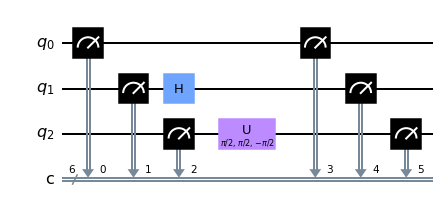

In [6]:
print( len(circuits_mpt) )
circuits_mpt[5].draw(output='mpl')

In [7]:
def merge_node(G):
    nodes_new = []
    for node in list( G.nodes ):
        t = tuple()
        for j in range(2):
            ti = node[j]
            t = t + tuple(ti)
        t = tuple(set(t))
        nodes_new.append(t)
    return nodes_new

def get_edges( nodes ):
    n_nodes = len(nodes)
    edges = []
    for j in range(n_nodes):
        for k in range(j+1,n_nodes):
            if len( set(nodes[j]) & set(nodes[k]) ) > 0:
                edges.append( (nodes[j],nodes[k]) )

    return edges

In [8]:
import networkx as nx  
from main import get_backend_conectivity

coupling_map = get_backend_conectivity( backend )
num_qubits  = 7
n = 3

G = nx.Graph()
G.add_edges_from(coupling_map)
for j in range(n-1):
    G = nx.generators.line.line_graph(G)
if n == 3:
    nodes = merge_node(G)
    G = nx.Graph()
    for nodei in nodes:
        G.add_node(nodei) 
    G.add_edges_from( get_edges(nodes) )         
  
G_coloring = nx.coloring.greedy_color(G)      
degree = max( G_coloring.values() ) + 1      
parall_qubits = degree*[None]              
for x in G_coloring:
    if parall_qubits[G_coloring[x]] is None:  
        parall_qubits[G_coloring[x]] = []    
    parall_qubits[G_coloring[x]].append(x)   

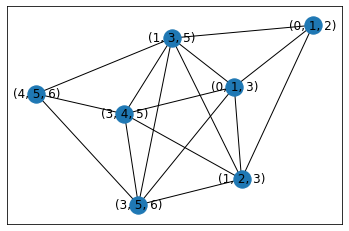

In [9]:
nx.draw_networkx(G)

In [10]:
parall_qubits

[[(1, 3, 5)],
 [(3, 5, 6), (0, 1, 2)],
 [(3, 4, 5)],
 [(0, 1, 3), (4, 5, 6)],
 [(1, 2, 3)]]

In [11]:
job = simulator.run( circuits_mpt, shots=1 )

In [12]:
results = job.result() 

In [13]:
out = mpt.fit(results)
out